<a href="https://colab.research.google.com/github/alexzhab/image-processing/blob/main/transfer_learning_facepoints_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U imgaug

In [2]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os
from skimage import io, transform
import cv2

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 5
NUM_KEYPOINTS = 68 * 2  # 24 pairs each having x and y coordinates

In [4]:
KEYPOINT_DEF = ("/content/faces/face_landmarks.csv")
IMG_DIR = "/content/faces/"

In [5]:
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [6]:
labels = keypoint_def["image_name"].values.tolist()

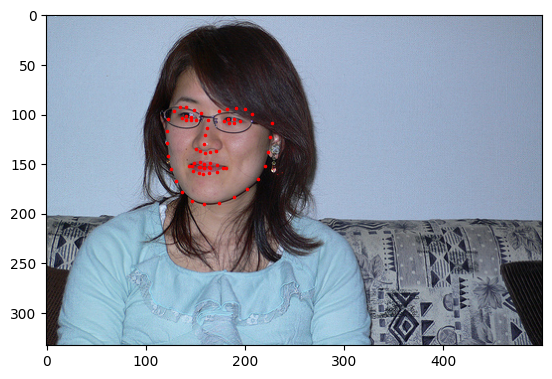

In [23]:
n = 7
img_name = keypoint_def.iloc[n, 0]
landmarks = keypoint_def.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('/content/faces/', img_name)),
               landmarks)
plt.show()

In [24]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, keypoints_pd, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.landmarks_frame = keypoints_pd
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        if self.train:
           image_keys_temp = [k + 10 for k in indexes]
        else:
           image_keys_temp = [k for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty((self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32")

        for i, _ in enumerate(image_keys_temp):
            landmarks = self.landmarks_frame.iloc[i, 1:]
            landmarks = np.asarray(landmarks)
            landmarks = landmarks.astype('float').reshape(-1, 2)
            current_keypoint = landmarks[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = plt.imread(os.path.join(IMG_DIR, self.landmarks_frame.iloc[i, 0]))
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 68 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

In [25]:
class KeyPointsTest(keras.utils.Sequence):
    def __init__(self, list_, batch_size=BATCH_SIZE):
        self.list_names = list_
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_names) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_names))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [k for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty((self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32")

        for i, _ in enumerate(image_keys_temp):
            current_image = plt.imread(os.path.join("/content/init/", self.list_names[i]))
            batch_images[i,] = current_image

            kp_temp = []
            for keypoint in range(68):
                kp_temp.append(0)
                kp_temp.append(0)
            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 68 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

In [26]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.5, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [27]:
samples = labels
train_keys, validation_keys = (
    samples[10:],
    samples[:10],
)

In [28]:
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], color = 'red', marker=".", s=50, linewidths=2)
        else:
            current_keypoint = np.array(current_keypoint)
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], color = 'red', marker=".", s=50, linewidths=2)

    plt.tight_layout(pad=2.0)
    plt.show()

Total batches in training set: 7
Total batches in validation set: 1


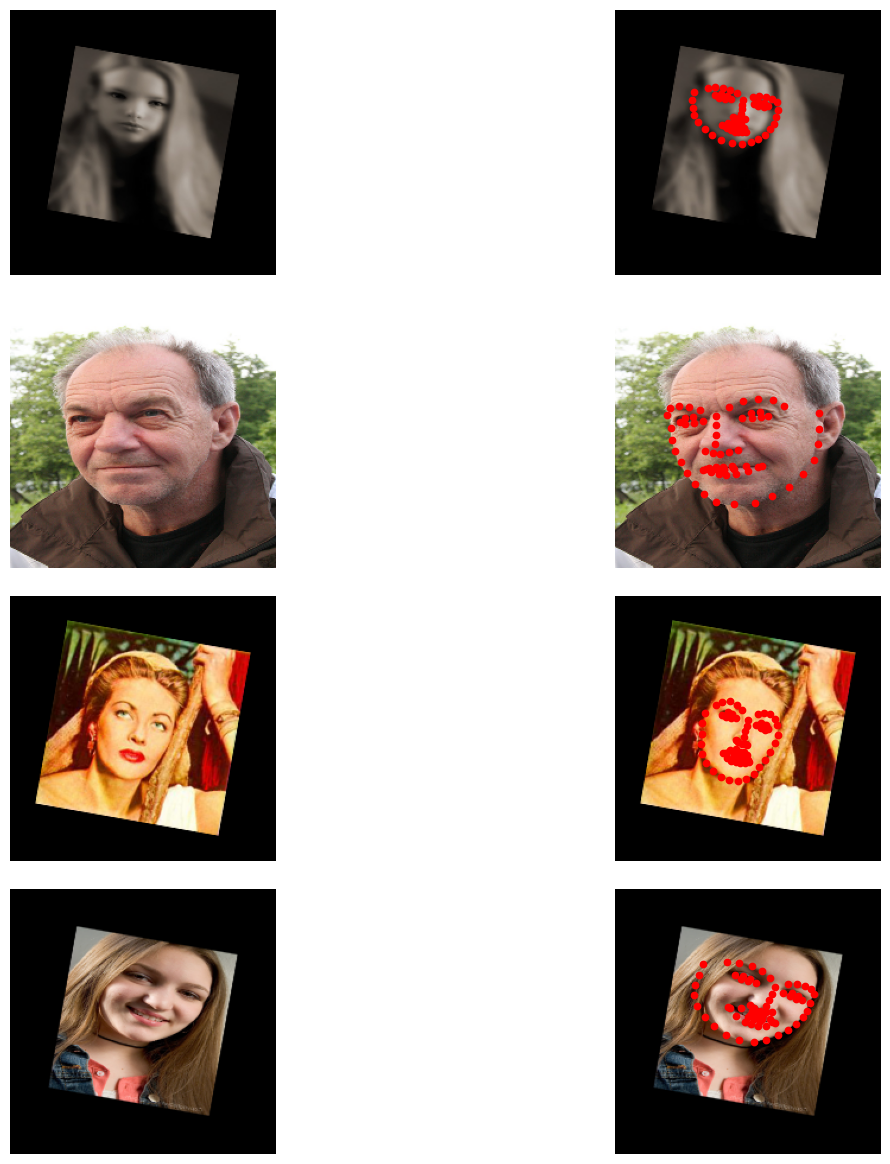

In [30]:
train_dataset = KeyPointsDataset(keypoint_def, train_keys, train_aug)
validation_dataset = KeyPointsDataset(keypoint_def, validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))

sample_keypoints = sample_keypoints[:4].reshape(-1, 68, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

In [31]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu")(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [32]:
get_model().summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)     

In [33]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [42]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4), metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=300)

7/7 [==============================] - 5s 340ms/step - loss: 0.0233 - accuracy: 0.0000e+00 - val_loss: 0.0332 - val_accuracy: 0.0000e+00


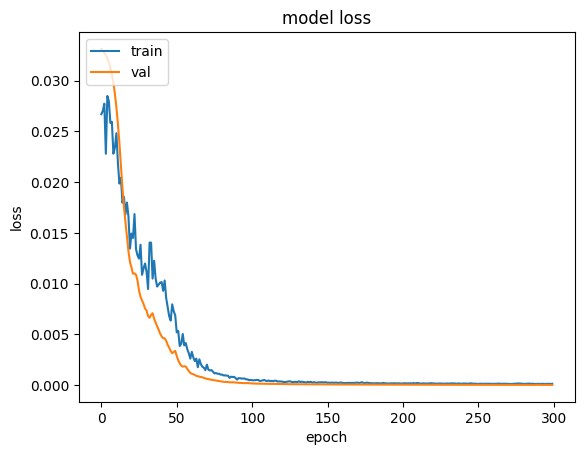

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
print("Evaluate on test data")
results = model.evaluate(sample_val_images, sample_val_keypoints, batch_size=8)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 0s 41ms/step - loss: 1.9383e-05 - accuracy: 0.7500
test loss, test acc: [1.9382852769922465e-05, 0.75]


1/1 [==============================] - 0s 27ms/step


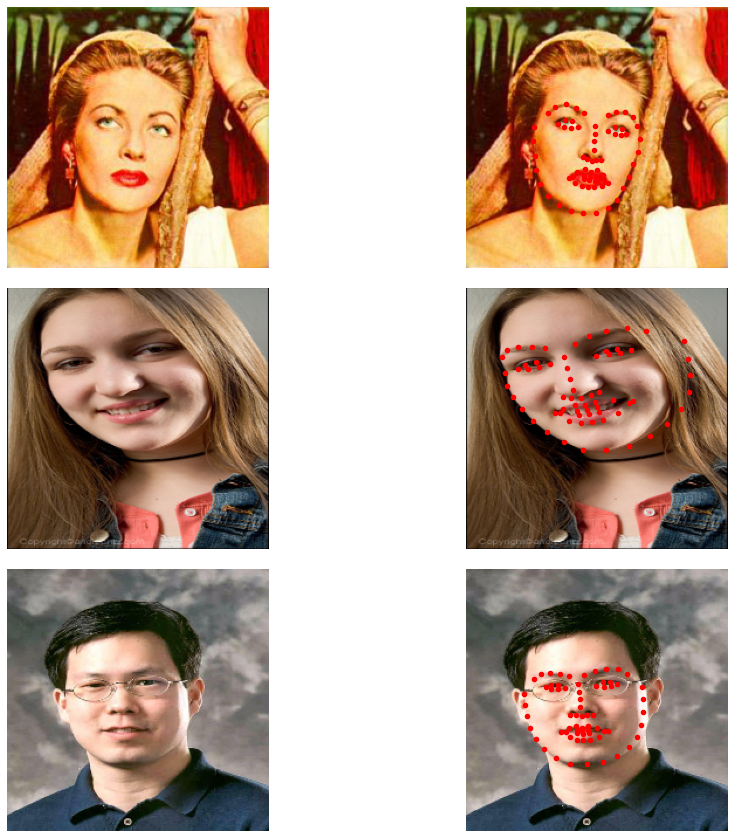

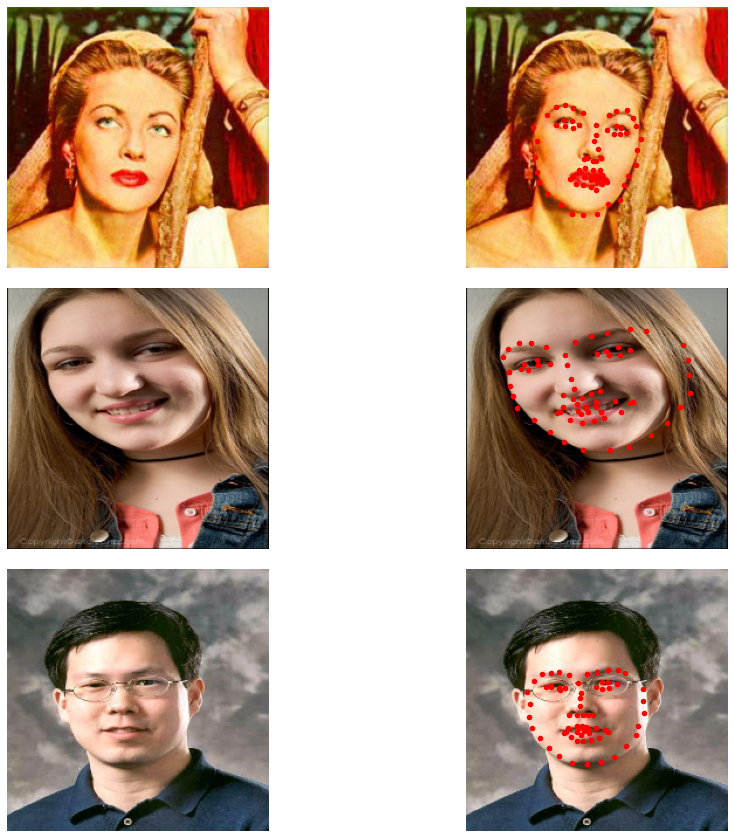

In [ ]:
sample_val_images = sample_val_images[2:5]
sample_val_keypoints = sample_val_keypoints[2:5].reshape(-1, 68, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 68, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)
# Predictions
visualize_keypoints(sample_val_images, predictions)